In [40]:
from numpy import asarray, pi, exp, sqrt
from cv2 import imread
# visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
# progress bar
from tqdm import tqdm_notebook as tqdm

rcParams['figure.figsize'] = 15,10
rcParams['image.cmap'] = 'Greys_r'
%matplotlib inline

In [58]:
im1 = imread('./task1.png',0)
im2 = imread('./task2.jpg',0)

<a id='notebook_top'></a>
[Task 2](#task2)    
[Task 3](#task3)

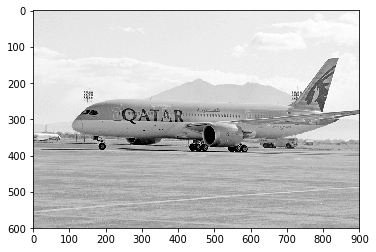

In [61]:
plt.imshow(im1)

### approach 0

In [62]:
def pad(arr):
    if type(arr[0][0]) is list:
        ins = [0,0,0]
    else:
        ins = 0
        
    for row in arr:
        row.insert(0,ins)
        row.append(ins)

    arr.insert(0, [ins for x in arr[0]])
    arr.append([ins for x in arr[0]])

class Kernel():
    def __init__(self, lst):
        self.data = lst
        self.size = len(lst)
        self.middle = self.size // 2
    
    def __getitem__(self,idx):
        return self.data[self.middle - idx[0]][self.middle - idx[1]]
    
    def t(self):
        return Kernel([[k[i] for k in self.data] for i in range(len(self.data))])

def conv0(arr, kernel):
    assert type(arr) is list, "arr should be a list"
    assert type(kernel) is Kernel, "kernel should be of type Kernel"
    kernel_size = kernel.size
    pad_size = kernel_size // 2
    for i in range(pad_size):
        pad(arr)
        
    res = []
    for i in range(pad_size, len(arr) - pad_size):
        res.append([])
        for j in range(pad_size, len(arr[0]) - pad_size):
            c = 0
            for m in range(-pad_size, pad_size + 1):
                for n in range(-pad_size, pad_size + 1):
                    c+= arr[i+m][j+n]*kernel[m,n]
            res[i-pad_size].append(c)
    return res

### approach 1

In [63]:
# def conv(arr, kernel):
#     padding = tuple(np.floor_divide(kernel.shape,2))
#     if len(arr.shape)==3:
#         arr_ = arr.sum(axis=2)
#     else:
#         arr_ = arr
#     arr_p = np.pad(arr_, padding, mode='constant', constant_values=0)
#     temp = np.lib.stride_tricks.as_strided(arr_p, arr_.shape + kernel.shape, arr_p.strides + arr_p.strides)
#     return np.reshape(
#         [(x*kernel[::-1,::-1]).sum() for x in temp.reshape(-1,*kernel.shape)], arr_.shape
#     )

### approach 2, better using numpy vectorization

In [64]:
# def conv2(arr, kernel):
#     padding = tuple(np.floor_divide(kernel.shape,2))
#     if len(arr.shape)==3:
#         arr_ = arr.sum(axis=2)
#     else:
#         arr_ = arr
#     arr_p = np.pad(arr_, padding, mode='constant', constant_values=0)
#     temp = np.lib.stride_tricks.as_strided(arr_p, arr_.shape + kernel.shape, arr_p.strides + arr_p.strides)
    
#     return np.sum(
#         [temp[:,:,i,j]*kernel[2-i,2-j] for i in range(kernel.shape[0]) for j in range(kernel.shape[1])],
#         axis=0
#     )

### importing scipy implementation for comparison

In [65]:
# from scipy.signal import convolve2d

### post_processing

In [66]:
def post_proc(img):
    max_val = max(map(max, img))
    min_val = min(map(min, img))
    img = asarray(img)
    res1 = (img - min_val) / (max_val - min_val)
    res2 = abs(img)/max(max_val,-min_val)
    return res1,res2

### speed test

In [67]:
kernel = Kernel([[-1,0,1],[-2,0,2],[-1,0,1]])

In [68]:
%%time
_ = conv0(im1.tolist(), kernel)

CPU times: user 6.69 s, sys: 36 ms, total: 6.73 s
Wall time: 6.73 s


In [69]:
# %%timeit
# conv(im1, kernel)

In [70]:
# %%timeit
# conv2(im1, kernel)

In [71]:
# %%timeit
# convolve2d(im1.sum(axis=2), kernel, mode='same')

### correctness test

In [72]:
# np.all(conv(im1, kernel) == conv2(im1, kernel)) and \
# np.all(conv2(im1,kernel) == convolve2d(im1.sum(axis=2), kernel, mode='same')) and \
# np.all(conv2(im1,kernel) == np.asarray(conv0(im1.tolist(), kernel0)))

### sobel filtering

In [73]:
# def sobel(img):
#     """computes gradient magnitude"""
#      kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
#     Gx = conv2(img, kernel)
#     Gy = conv2(img, kernel.T)
#     return np.sqrt(Gx**2 + Gy**2)

### results visualization

In [74]:
Gx = post_proc(conv0(im1.tolist(),kernel))
Gy = post_proc(conv0(im1.tolist(),kernel.t()))

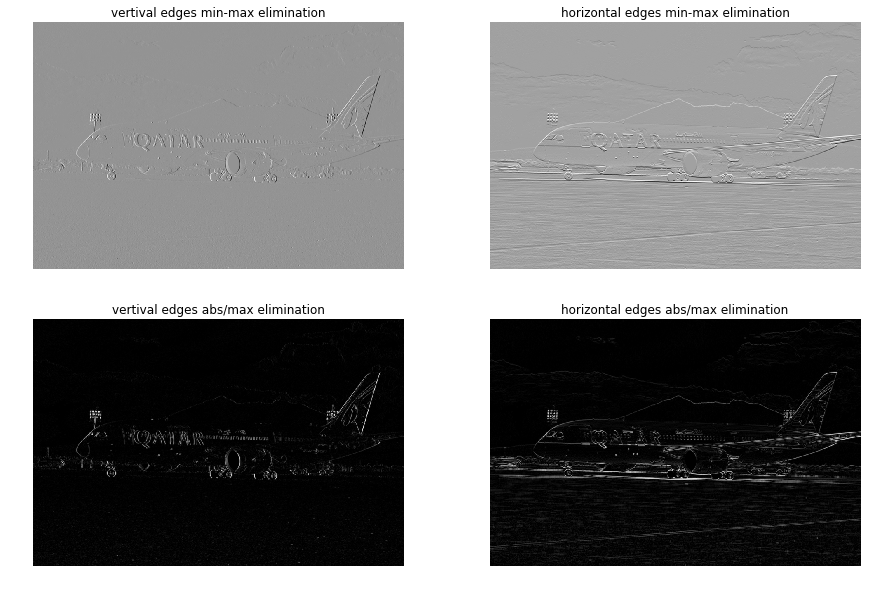

In [75]:
f,ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].imshow(Gx[0], cmap='Greys_r')
ax[0,0].set_title('vertival edges min-max elimination')
ax[0,1].imshow(Gy[0], cmap='Greys_r')
ax[0,1].set_title('horizontal edges min-max elimination')

ax[1,0].imshow(Gx[1], cmap='Greys_r')
ax[1,0].set_title('vertival edges abs/max elimination')
ax[1,1].imshow(Gy[1], cmap='Greys_r')
ax[1,1].set_title('horizontal edges abs/max elimination')

for a in ax.ravel():
    a.axis('off')

---
### Task 2
<a id='task2'></a>
[go to the top](#notebook_top)

(-0.5, 749.5, 457.5, -0.5)

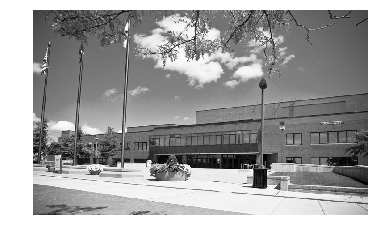

In [78]:
plt.imshow(im2)
plt.axis('off')

In [79]:
octaves = {
    1: [1/sqrt(2), 1, sqrt(2), 2, 2*sqrt(2)],
    2: [sqrt(2), 2, 2*sqrt(2), 4, 4*sqrt(2)],
    3: [2*sqrt(2), 4, 4*sqrt(2), 8, 8*sqrt(2)],
    4: [4*sqrt(2), 8, 8*sqrt(2), 16, 16*sqrt(2)]
}

---

computing dogs

In [80]:
def Gauss(sigma):
    def f(x,y):
        return 1/(2*pi*sigma**2)*exp(-(x**2+y**2)/(2*sigma**2))
    return f

def np_meshgrid(rng):
    X = [list(rng) for x in range(len(rng))]
    Y = [[k[i] for k in X] for i in range(len(X))]
    return asarray(X),asarray(Y)

def normalize(x):
    return x / sum(sum(x))

def GKernel(sigma,size=7):
    return Kernel(
        normalize(
            Gauss(sigma)(*np_meshgrid(range(-size//2+1,size//2+1)))
        )
    )

def pyraimd_up(img):
    if type(img) is list:
        return asarray(img)[::2,::2].tolist()
    else:
        return img[::2,::2]

X,Y = np_meshgrid(range(-3,4))

In [81]:
img_pyramid = [im2]
for i in range(3):
    img_pyramid.append(pyraimd_up(img_pyramid[-1]))

In [43]:
oct_images = {
    k: [conv0(im2.tolist(), GKernel(sigma)) for sigma in tqdm(v)] for k,v in octaves.items()
}

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [44]:
def DoG(oct_images):
    return {
        k: [asarray(im1) - asarray(im0) for im0,im1 in zip(ar[:-1],ar[1:])] for k, ar in oct_images.items()
    }

In [45]:
dogs = DoG(oct_images)

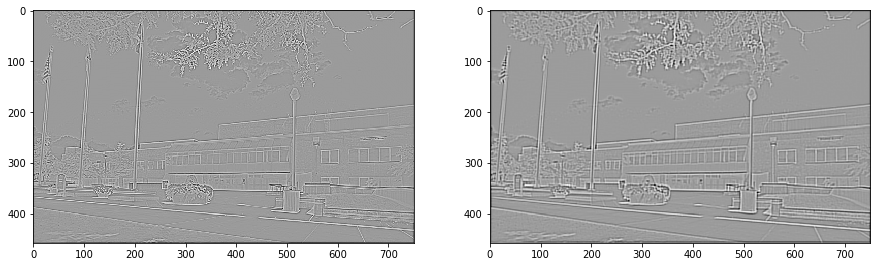

In [46]:
f,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(
    dogs[1][0], cmap='Greys_r'
)
ax[1].imshow(
    dogs[1][3], cmap='Greys_r'
)

finding keypoints

In [ ]:
def ravel(arr):
    return [x for y in arr for x in y]

def check_point(subdogs, i,j):
    val = subdogs[1][i,j]
    si = slice(i-1,i+2)
    sj = slice(j-1,j+2)
    
    lvls = [ravel(s[si,sj].tolist()) for s in subdogs]
    lvls[1].pop(4) #popping the value itself
    candidates = ravel(lvls)
    min_ = min(candidates)
    max_ = max(candidates)
    return (val > max_) | (val < min_)

def find_keypoints(triplet, octave, depth):
    h,w = triplet[0].shape
    res = [[]]
    for i in range(1,h-1):
        for j in range(1,w-1):
            res[i-1].append(check_point(triplet,i,j))
        res.append([])
    res.pop()
    pad(res);
    return res

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(
    im2_grey + np.asarray(res)*255, cmap='Greys_r'
)
plt.axis('off')

---
### Task3
<a id='task3'></a>
[go to the top](#notebook_top)

In [ ]:
import cv2
from collections import Counter
from tqdm import tqdm_notebook as tqdm
from matplotlib.patches import Rectangle

In [ ]:
img_names = !ls ./task3 | grep jpg | grep -v template

In [ ]:
imgs = [cv2.cvtColor(cv2.imread('./task3/'+i),cv2.COLOR_BGR2HSV) for i in img_names]

In [ ]:
def match_template(image, template, mask):
    """performs masked correlation matching"""
    shape = tuple(np.subtract(image.shape,template.shape))
    im_r = np.lib.stride_tricks.as_strided(image, shape+template.shape, image.strides + image.strides)
    ccor = (
        (im_r - im_r.mean(axis=(2,3))[:,:,np.newaxis,np.newaxis]) * (template - template.mean())[np.newaxis,np.newaxis,:,:] * mask[np.newaxis,np.newaxis,:,:]
    ).sum(axis=(2,3))
    ccor[ccor < 0] = 0
    ccor = ccor / ccor.max()
    res = cv2.minMaxLoc(ccor)
    return res[1], res[3]

def match_template2(image, template, mask):
    """normalizes image batch-wise and performs masked correlation matching"""
    shape = tuple(np.subtract(image.shape,template.shape))
    im_r = np.lib.stride_tricks.as_strided(image, shape+template.shape, image.strides + image.strides) * mask[np.newaxis, np.newaxis,:,:]
    
    im_r = im_r - im_r.min(axis=(2,3))[:,:,np.newaxis,np.newaxis]
    im_r = im_r / (im_r.max(axis=(2,3)) + 0.1)[:,:,np.newaxis,np.newaxis]
    
    template = template - template.min()
    template = template / template.max() + 0.1
    
    ccor = (
        (im_r - im_r.mean(axis=(2,3))[:,:,np.newaxis,np.newaxis]) * (template - template.mean())[np.newaxis,np.newaxis,:,:] * mask[np.newaxis,np.newaxis,:,:]
    ).sum(axis=(2,3))
    ccor[ccor < 0] = 0
    ccor_max = ccor.max()
    ccor = ccor / ccor_max
    return ccor_max, cv2.minMaxLoc(ccor)[3]

helper = lambda im, mask, scale: (cv2.resize(im, None, fx=scale, fy=scale), cv2.resize(mask, None, fx=scale, fy=scale))

def find_cursor(image, template, mask):
    scale_range = np.linspace(0.8,1.1,num=8)
    matches = [match_template2(image,*helper(template, mask, scale)) for scale in tqdm(scale_range)]
    confidence = [x[0] / s**2 for x,s in zip(matches, scale_range)]
    loc = [x[1] for x in matches]
    mode = Counter(loc).most_common()
    return mode[0], (confidence, loc)

### DoG approach

In [ ]:
def doggo(im_v):
    return cv2.GaussianBlur(im_v, (5,5), 8*np.sqrt(2)).astype('float32') - cv2.GaussianBlur(im_v, (5,5), 3*np.sqrt(2))

def find_candidates(img, sc_temps):
    dog = doggo(img)
    locs = [cv2.minMaxLoc(
                cv2.matchTemplate(dog, tmp, cv2.TM_CCORR_NORMED)
            )[3] for tmp in sc_temps]
    shapes = [s.shape for s in sc_temps]
    matches = [
        cv2.resize(
            img[l[1]:l[1]+s[0],l[0]:l[0]+s[1]], (10,15)
        ) for l,s in zip(locs, shapes)
    ]
    
    std = [(l,m.std()) for l,m in zip(locs, matches)]
    
    return locs, matches

def find_best_one(template, locs, matches):
    sobel11 = cv2.Sobel(template, 2, 1, 1)
    sobel10 = cv2.Sobel(template, 2, 1, 0)
    canny_t = cv2.Canny(template, 10, 100)
    canny_t[0,:] = 0 #masking background
    canny_t[:,0] = 0
    
    s_score_func = lambda x: (
        cv2.Sobel(x,2,1,0) & sobel10
    ).sum() * 0.5 + (
        cv2.Sobel(x,2,1,1) & sobel11
    ).sum() * 0.5
    
    c_score_func = lambda x: (cv2.Canny(x, 10, 100) & canny_t).sum()
    
    s_scores = [s_score_func(x) for x in matches]
    c_scores = [c_score_func(x) for x in matches]
    
    scores = [ss*0.6+cs*0.4 for ss,cs in zip(s_scores, c_scores)]
    best = np.argmax(scores)
    
    return (locs[best], matches[best], scores[best]) if scores[best] > 4500 else None

def plot(image, detect_res=None):
    f,ax = plt.subplots(1,1,figsize=(20,10))
    ax.imshow(image[:,:,2], cmap='Greys_r')
    if detect_res:
        loc = detect_res[0]
        ax.add_patch(
            Rectangle((loc[0],loc[1]),10,15,linewidth=1,edgecolor='r',facecolor='none')
        )
    return f,ax

In [ ]:
img_names[10]

In [ ]:
dog = doggo(imgs[10][:,:,2])

template = dog[273:288,865:875]
templ_orig = imgs[10][273:288,865:875,2]
sc_temps = [cv2.resize(template,None, fx=s, fy=s) for s in np.linspace(0.7, 1.1, 16)]

In [ ]:
res = [
    find_best_one(templ_orig, *find_candidates(img[:,:,2], sc_temps)) for img in tqdm(imgs)
]

In [ ]:
i = 7

In [ ]:
i += 1
print(img_names[i])
plot(imgs[i],res[i])